In [1]:
!pip install segment-geospatial

You should consider upgrading via the 'C:\Users\PC\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Utils functions

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# YOLOv8 trained on custom bubbles dataset

In [3]:
from ultralytics import YOLO

custom_yolo_checkpoint_path = r"C:\Internship\ITMO ML\CTCI\checkpoints\yolov8\yolov8s_on_bubbles_24\run3\weights\best.pt"

detector = YOLO(custom_yolo_checkpoint_path)

In [4]:
image = cv2.imread(r'C:\Internship\ITMO ML\CTCI\data\frame-0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

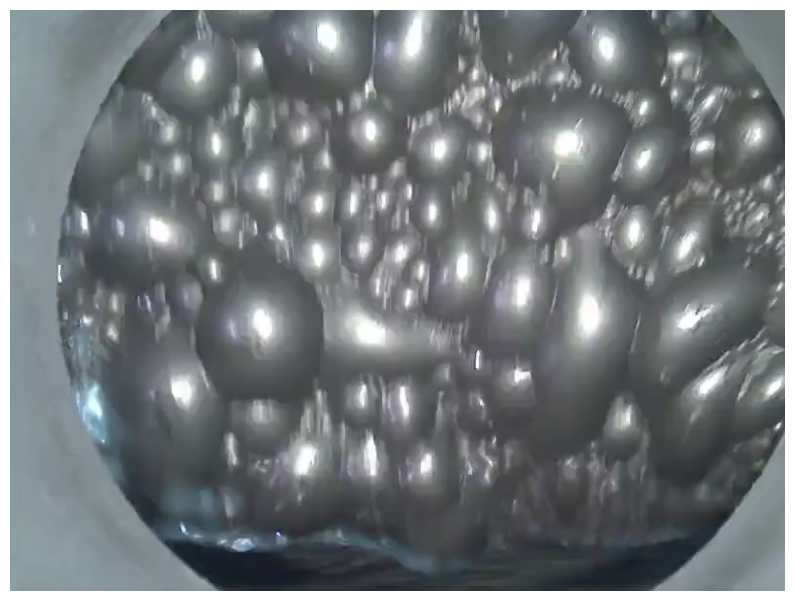

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
objects = detector(image)
objects

0: 608x800 262 Bubbless, 160.4ms
Speed: 5.0ms preprocess, 160.4ms inference, 213.1ms postprocess per image at shape (1, 3, 608, 800)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Bubbles'}
 orig_img: array([[[134, 153, 159],
         [134, 153, 159],
         [134, 153, 159],
         ...,
         [111, 123, 123],
         [111, 123, 123],
         [111, 123, 123]],
 
        [[134, 153, 159],
         [134, 153, 159],
         [134, 153, 159],
         ...,
         [111, 123, 123],
         [111, 123, 123],
         [111, 123, 123]],
 
        [[134, 153, 159],
         [134, 153, 159],
         [135, 154, 160],
         ...,
         [111, 123, 123],
         [111, 123, 123],
         [111, 123, 123]],
 
        ...,
 
        [[142, 160, 158],
         [142, 160, 158],
         [142, 160, 158],
         ...,
         [144, 156, 159],
         [145, 157, 160],
         [145, 157, 160]],
 
        [[144, 160, 159],
         [144, 160, 159],
         [144, 160, 159],
         ...,
         [145, 156, 159],
  

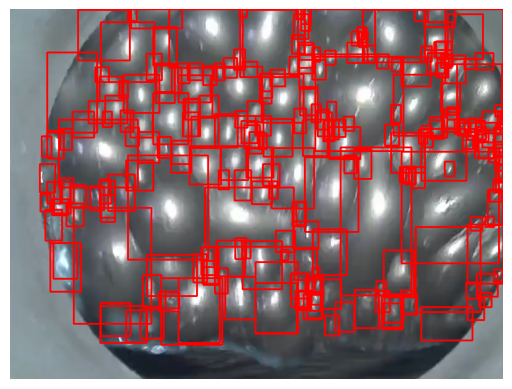

In [7]:
boxes = objects[0].boxes.xyxy.tolist()

image_example = image.copy()

for box in boxes:
    x1, y1, x2, y2 = box
    
    w, h = x2 - x1, y2 - y1
    plt.Rectangle((x1, y1), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)
    cv2.rectangle(image_example, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

plt.imshow(image_example)
plt.axis('off')
plt.show()

# SAM Checkpoint

In [9]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = r"C:\Internship\ITMO ML\CTCI\checkpoints\sam_checkpoints\sam_vit_h_4b8939.pth"
model_type = "vit_h"
device="cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

# Segmentation by bounding box prompt

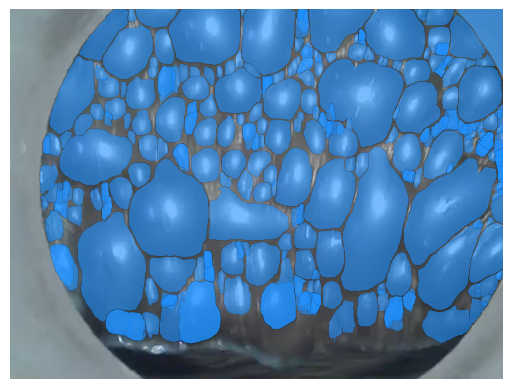

In [10]:
plt.figure()
plt.imshow(image)

predictor.set_image(image)
for box in boxes:
    box = np.array(box)
    masks, _, _ = predictor.predict(
        box=box,
        multimask_output=False
    )
    
    show_mask(masks[0], plt.gca())
    #show_box(box, plt.gca())
    
plt.axis('off')
plt.show()

# Segmentation by bounding box and point prompt

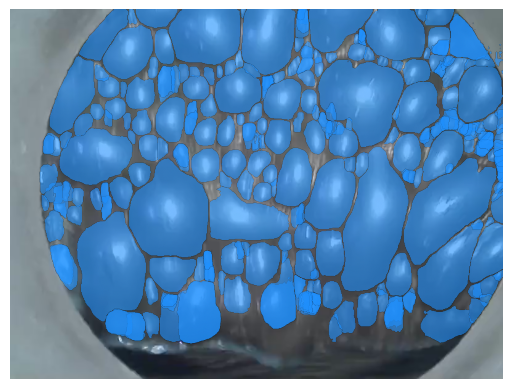

In [12]:
plt.figure()
plt.imshow(image)

predictor.set_image(image)
for box in boxes:
    box = np.array(box)
    point = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]])
    labels = np.array([1])
    masks, _, _ = predictor.predict(
        box=box,
        point_coords=point,
        point_labels=labels,
        multimask_output=False
    )
    
    show_mask(masks[0], plt.gca())
    #show_box(box, plt.gca())
    
plt.axis('off')
plt.show()

# Segmentation by text prompt

In [13]:
from samgeo.text_sam import LangSAM

sam_text = LangSAM()

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:37<00:00, 67.5MB/s]


In [14]:
text_prompt = "bubble"

sam_text.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)

sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Automatic Segmentation of Trees',
)

TypeError: cannot unpack non-iterable int object